In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import sys
sys.path.append('../..') 
import evaluation
sys.path.append('../') 
import utils

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [3]:
from fastcore.basics import Path, AttrDict

In [4]:
import matplotlib.pyplot as plt

In [5]:
config = AttrDict(
    challenge_data_dir = Path('D:/SPLID/splid-devkit/data').expanduser(),
    valid_ratio = 0.1,
    lag_steps = 5
)

In [6]:
# Define the list of feature columns
feature_cols = [
    "Eccentricity",
    "Semimajor Axis (m)",
    "Inclination (deg)",
    "RAAN (deg)",
    "Argument of Periapsis (deg)",
    "True Anomaly (deg)",
    "Latitude (deg)",
    "Longitude (deg)",
    "Altitude (m)",
    "X (m)",
    "Y (m)",
    "Z (m)",
    "Vx (m/s)",
    "Vy (m/s)",
    "Vz (m/s)"
]

In [7]:
# Define the directory paths
train_data_dir = config.challenge_data_dir / "train"

# Load the ground truth data
ground_truth = pd.read_csv(config.challenge_data_dir / 'train_labels.csv')

# Apply the function to the ground truth data
data, updated_feature_cols = utils.tabularize_data(train_data_dir, feature_cols, 
                                          ground_truth, lag_steps=config.lag_steps)

# For each ObjectID, show the first rows of the columns TimeIndex, ObjectID, EW, and NS
data[['ObjectID', 'TimeIndex' , 'EW', 'NS']].groupby('ObjectID').head(2).head(10)

,ObjectID,TimeIndex,EW,NS
0,1,0,SS-HK,SS-HK
1,1,1,SS-HK,SS-HK
0,10,0,SS-CK,SS-NK
1,10,1,SS-CK,SS-NK
0,100,0,SS-CK,SS-CK
1,100,1,SS-CK,SS-CK
0,101,0,SS-CK,SS-NK
1,101,1,SS-CK,SS-NK
0,102,0,SS-CK,SS-NK
1,102,1,SS-CK,SS-NK


In [8]:
# Create a validation set without mixing the ObjectIDs
object_ids = data['ObjectID'].unique()
train_ids, valid_ids = train_test_split(object_ids, 
                                        test_size=config.valid_ratio, 
                                        random_state=42)

train_data = data[data['ObjectID'].isin(train_ids)].copy()
valid_data = data[data['ObjectID'].isin(valid_ids)].copy()

ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(train_ids)].copy()
ground_truth_valid = ground_truth[ground_truth['ObjectID'].isin(valid_ids)].copy()

# Count the number of objects in the training and validation sets
print('Number of objects in the training set:', len(train_data['ObjectID'].unique()))
print('Number of objects in the validation set:', len(valid_data['ObjectID'].unique()))

Number of objects in the training set: 225
Number of objects in the validation set: 25


In [9]:
len(train_data)

490416

In [10]:
len(valid_data)

54444

In [22]:
len(data)

544860

In [15]:
data.describe()

,Eccentricity,Semimajor Axis (m),Inclination (deg),RAAN (deg),Argument of Periapsis (deg),True Anomaly (deg),Latitude (deg),Longitude (deg),Altitude (m),X (m),...,Vy (m/s)_lag_1,Vy (m/s)_lag_2,Vy (m/s)_lag_3,Vy (m/s)_lag_4,Vy (m/s)_lag_5,Vz (m/s)_lag_1,Vz (m/s)_lag_2,Vz (m/s)_lag_3,Vz (m/s)_lag_4,Vz (m/s)_lag_5
count,544860.000000,5.448600e+05,544860.000000,544860.000000,544860.000000,544860.000000,544860.000000,544860.000000,5.448600e+05,5.448600e+05,...,544860.000000,544860.000000,544860.000000,544860.000000,544860.000000,544860.000000,544860.000000,544860.000000,544860.000000,544860.000000
mean,0.000777,4.217808e+07,0.308296,94.776187,154.400927,158.645411,0.000251,2.611029,3.579879e+07,3.507365e+04,...,2.114910,2.456722,2.673163,2.829026,3.005567,0.003046,0.002366,0.001121,-0.000412,-0.001879
std,0.001397,7.802169e+04,0.900648,19.557625,87.071663,120.645831,0.652997,90.190872,9.146158e+04,2.982243e+07,...,2173.863564,2173.979412,2174.084867,2174.135953,2174.142868,35.934310,35.931927,35.935565,35.940457,35.940614
min,0.000001,4.171377e+07,0.042754,41.693890,0.000645,-179.994062,-9.873823,-179.999986,3.515185e+07,-4.254933e+07,...,-3107.831169,-3107.831169,-3107.831169,-3107.831169,-3107.831169,-531.699273,-531.699273,-531.699273,-531.699273,-531.699273
25%,0.000238,4.216510e+07,0.132406,87.824396,85.238376,63.964989,-0.025258,-73.750163,3.577838e+07,-2.978574e+07,...,-2172.758695,-2172.597138,-2172.758695,-2173.021239,-2173.021239,-5.744057,-5.745389,-5.746372,-5.746939,-5.748209
50%,0.000335,4.216592e+07,0.152710,94.497250,141.833084,156.741005,0.000309,-7.015789,3.578782e+07,8.836196e+04,...,6.628235,7.171746,7.952763,8.331679,8.372964,0.003102,-0.002169,-0.003558,-0.004599,-0.006147
75%,0.000524,4.216674e+07,0.186747,99.905521,207.623242,262.511639,0.025819,42.017629,3.579692e+07,2.985488e+07,...,2176.062969,2176.062969,2176.062969,2176.062969,2176.062969,5.747088,5.743210,5.740246,5.738686,5.736524
max,0.007778,4.260272e+07,9.970447,354.167229,359.998736,359.999155,9.874416,359.782205,3.633733e+07,4.258594e+07,...,3094.457324,3094.457324,3094.457324,3094.457324,3094.457324,532.071842,532.071842,532.071842,532.071842,532.071842


In [11]:
# Convert categorical data to numerical data
le_EW = LabelEncoder()
le_NS = LabelEncoder()

# Encode the 'EW' and 'NS' columns
train_data['EW_encoded'] = le_EW.fit_transform(train_data['EW'])
train_data['NS_encoded'] = le_NS.fit_transform(train_data['NS'])

In [16]:
train_data_X = train_data.iloc[:,:-5].values

In [13]:
train_data_Y_EW = train_data.iloc[:,-2].values
train_data_Y_NS = train_data.iloc[:,-1].values

In [34]:
y_train = train_data['EW_encoded']

In [37]:
y_train.shape[1]

IndexError: tuple index out of range

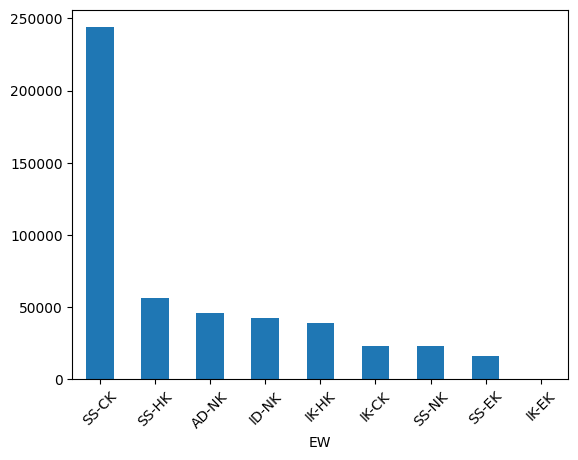

In [55]:
train_data['EW'].value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

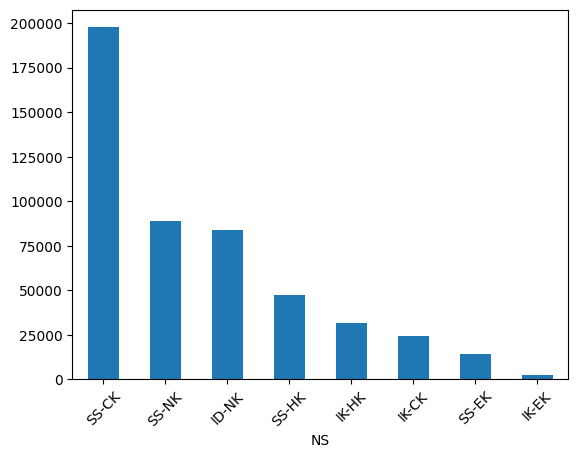

In [56]:
train_data['NS'].value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

In [21]:
# Standardize the data
scaler = StandardScaler()
train_data_X = scaler.fit_transform(train_data_X)

In [22]:
# Reshape the data for LSTM input (samples, time steps, features)
train_data_X = train_data_X.reshape((train_data_X.shape[0],1,train_data_X.shape[1]))

In [44]:
# Build the LSTM model for multi-class classification
EW_model = Sequential()
EW_model.add(LSTM(50, return_sequences=True,input_shape=(train_data_X.shape[1], train_data_X.shape[2])))
EW_model.add(Dropout(0.2))
EW_model.add(LSTM(50, return_sequences=False))
EW_model.add(Dropout(0.2))
EW_model.add(Dense(9, activation='softmax'))  # Output layer for multi-class classification

In [45]:
# Compile the model
EW_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
EW_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 50)             28600     
                                                                 
 dropout_6 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 9)                 459       
                                                                 
Total params: 49259 (192.42 KB)
Trainable params: 49259 (192.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
#Train the model
EW_model.fit(train_data_X, train_data_Y_EW, epochs=10, batch_size=32,validation_split=0.2)

Epoch 1/10
12261/12261 [==============================] - 54s 4ms/step - loss: 0.3217 - accuracy: 0.8801 - val_loss: 0.7747 - val_accuracy: 0.8427
Epoch 2/10
12261/12261 [==============================] - 48s 4ms/step - loss: 0.1614 - accuracy: 0.9400 - val_loss: 0.4087 - val_accuracy: 0.8960
Epoch 3/10
12261/12261 [==============================] - 48s 4ms/step - loss: 0.1330 - accuracy: 0.9509 - val_loss: 0.1973 - val_accuracy: 0.9382
Epoch 4/10
12261/12261 [==============================] - 48s 4ms/step - loss: 0.1196 - accuracy: 0.9559 - val_loss: 0.2171 - val_accuracy: 0.9505
Epoch 5/10
12261/12261 [==============================] - 48s 4ms/step - loss: 0.1114 - accuracy: 0.9589 - val_loss: 0.1074 - val_accuracy: 0.9675
Epoch 6/10
12261/12261 [==============================] - 49s 4ms/step - loss: 0.1046 - accuracy: 0.9610 - val_loss: 0.0913 - val_accuracy: 0.9724
Epoch 7/10
12261/12261 [==============================] - 50s 4ms/step - loss: 0.1012 - accuracy: 0.9621 - val_loss: 0

In [48]:
valid_data['EW_encoded'] = le_EW.fit_transform(valid_data['EW'])

In [61]:
valid_data_X = valid_data.iloc[:,:-4].values

In [66]:
valid_data_Y_EW = valid_data.iloc[:,-1].values

In [62]:
valid_data_X = scaler.fit_transform(valid_data_X)
valid_data_X = valid_data_X.reshape((valid_data_X.shape[0],1,valid_data_X.shape[1]))

In [63]:
# Make predictions
predictions = EW_model.predict(valid_data_X)

# If it's a classification model, convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)  # For multi-class classification
# For binary classification, you might use a threshold like 0.5 to convert probabilities to 0 or 1

# If you used label encoding, convert the numerical labels back to original labels
predicted_labels = le_EW.inverse_transform(predicted_classes)


1702/1702 [==============================] - 4s 2ms/step


ValueError: y contains previously unseen labels: [7 8]

In [69]:
predicted_classes

array([8, 8, 8, ..., 5, 2, 0], dtype=int64)